# Evaluation

## Imports & settings

In [85]:
import ast
import json
import shap
import numpy as np
import pandas as pd
from scipy.stats import norm
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

In [86]:
# Asset, quantile, model and target selection
symbol = "BTC"
quantile = "05_95"
trial_id = 3
target = "log_returns_7"

## Data loading

In [87]:
def read_market_data(path: str) -> pd.DataFrame:
    """
    Given a path to a file about an asset market data in CSV format, returns a pandas dataframe with the data,
    sorted by time dimension in ascending order.
    """
    # Reads file
    df = pd.read_csv(path, header=0, sep=',', parse_dates=True)

    # Sets date as index
    df.set_index('date', inplace=True)

    # Sorts the dataframe ascending by date
    df.sort_index(inplace=True)
    
    return df

market_data_path = Path(f"market_data/{symbol}.csv")
market_data = read_market_data(market_data_path)

In [88]:
# Loads the test set features
X_test = pd.read_csv(Path(f"derived_data/{symbol}/X_test.csv"))
X_test = X_test.set_index('date')

# Loads the test set targets
y_test = pd.read_csv(Path(f"derived_data/{symbol}/y_test.csv"))
y_test = y_test.set_index('date')

In [89]:
# Retrieves the model's architecture
architecture_path = Path(f"architectures/{symbol}/{quantile}/{trial_id}.json")

# Loads the architecture JSON file
with open(architecture_path, "r") as f:
    config = json.load(f)

window_size = config.get("window size")

## Model loading

In [90]:
# Retrieves the model
model_path = Path(f"models/{symbol}/{quantile}/{trial_id}_{target}.h5")

# Loads the model
model = load_model(model_path)

## Performance metrics

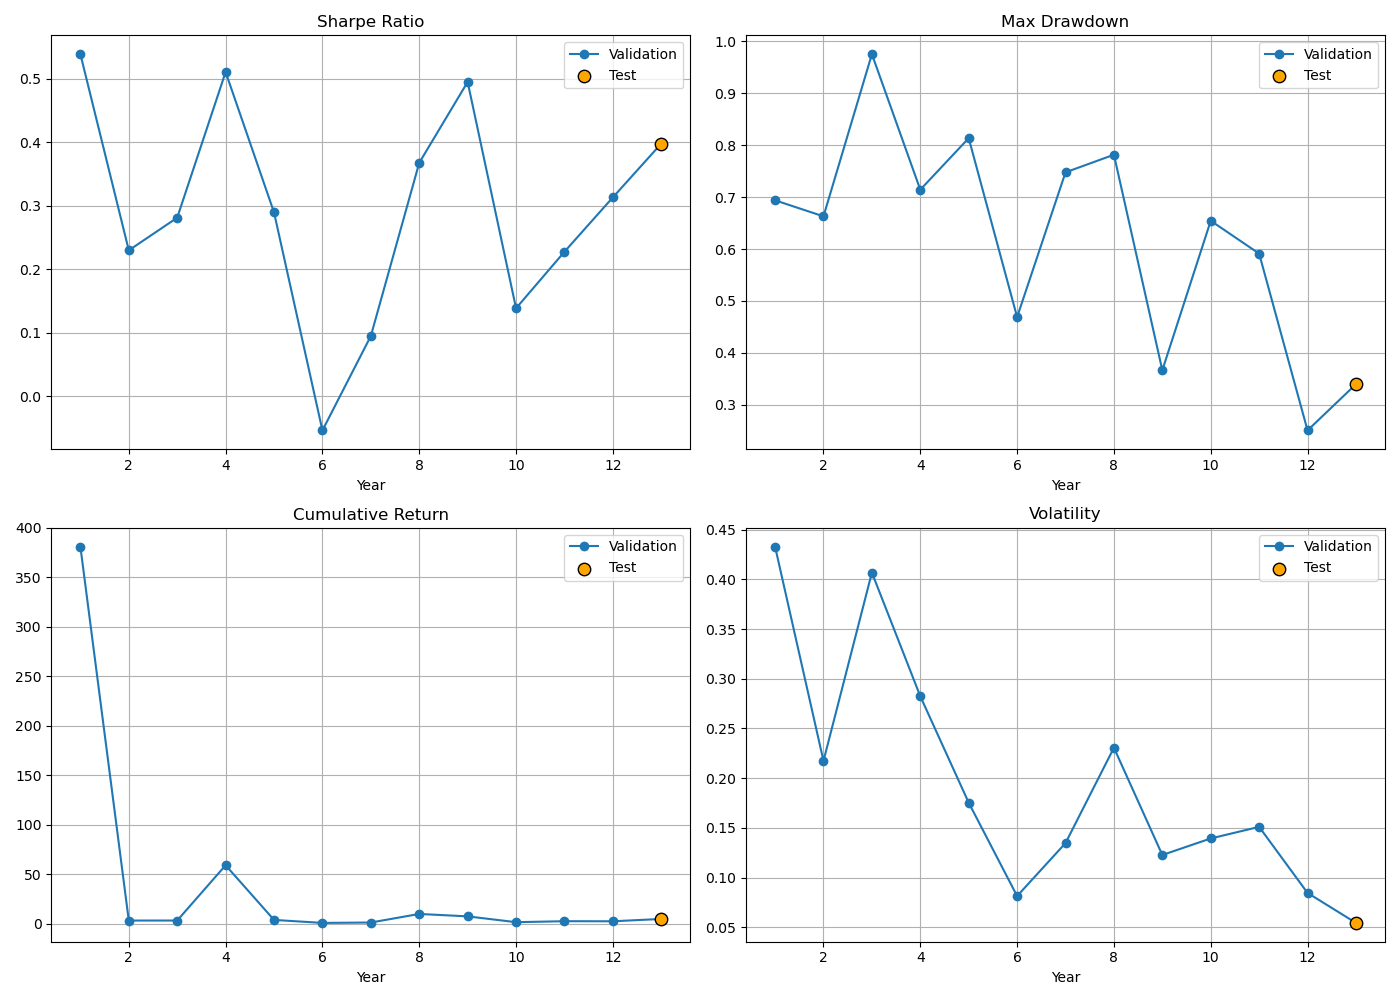

In [91]:
%matplotlib widget

# Retrieves related performance metrics
validation_performance_path = Path(f"logs/{symbol}/performance/validation/{quantile}/{trial_id}_{target}.csv")
test_performance_path = Path(f"logs/{symbol}/performance/test/{quantile}/generalization.csv")

# Loads model performance metrics
validation_df = pd.read_csv(validation_performance_path)

test_df = pd.read_csv(test_performance_path)
test_row = test_df[(test_df["trial_id"] == trial_id) & (test_df["target"] == target)].iloc[0]

# Aligns step axis (assumes validation is yearly)
validation_df["year"] = validation_df["step"] // 365
test_point_x = validation_df["year"].max()

# Defines the rolling metrics to plot
metrics = ["sharpe", "max_drawdown", "cumulative_return", "volatility"]
titles = ["Sharpe Ratio", "Max Drawdown", "Cumulative Return", "Volatility"]

plt.figure(figsize=(14, 10))

for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)

    # Copy validation data and append test point
    combined_years = list(validation_df["year"]) + [validation_df["year"].max() + 1]
    combined_values = list(validation_df[metric]) + [test_row[metric]]

    # Plots validation
    plt.plot(combined_years, combined_values, marker='o', label="Validation")

    # Highlights test point with a special marker
    plt.scatter(combined_years[-1], combined_values[-1], color='orange', edgecolors='black', zorder=5, s=80, label="Test")

    # Labels and title
    plt.title(titles[i])
    plt.xlabel("Year")
    plt.tight_layout()
    plt.grid(True)
    plt.legend()

plt.show()

In [92]:
def reshape_data(X, y, window_size):
    """
    Reshapes the datasets into input sequences and corresponding targets required for the model.
    """
    # Converts the dataframes to numpy arrays
    if isinstance(X, (pd.DataFrame, pd.Series)): X = X.values
    if isinstance(y, (pd.DataFrame, pd.Series)): y = y.values

    X_seq, y_seq = [], []

    for i in range(len(X) - window_size):
        X_seq.append(X[i:i+window_size])
        y_seq.append(y[i + window_size])

    return np.array(X_seq), np.array(y_seq)

# Keeps feature names
feature_names = X_test.columns

# Reshapes data
X_test_seq, y_test_seq = reshape_data(X_test, y_test[target], int(window_size))
y_true = pd.DataFrame(y_test_seq, columns=[target], index=y_test.index[int(window_size):])

In [93]:
# Evaluates generalization on test set
y_pred = model.predict(X_test_seq, verbose=0)
y_pred = pd.DataFrame(y_pred, columns=[target], index=y_true.index)

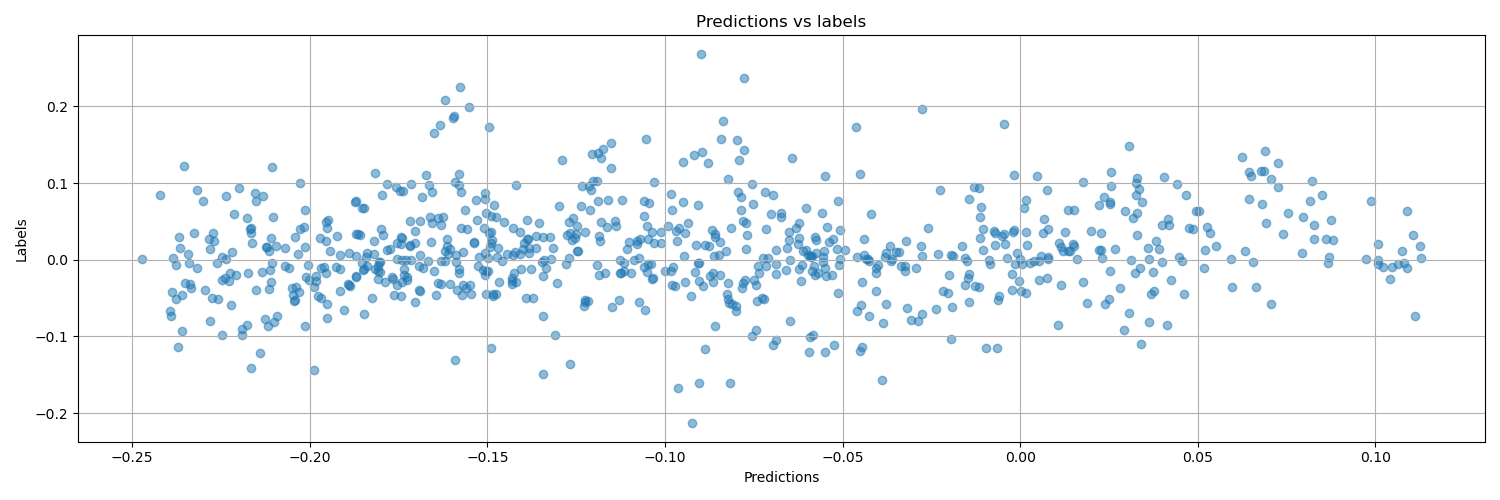

In [94]:
# Plots a scatter plot of the predictions vs the ground truth values
plt.figure(figsize=(15, 5))
plt.scatter(y_pred, y_true, alpha=0.5)
plt.title('Predictions vs labels')
plt.xlabel('Predictions')
plt.ylabel('Labels')
plt.tight_layout()
plt.grid()
plt.show()

In [95]:
def calculate_sharpe(y_true: pd.DataFrame, y_pred: pd.DataFrame, lower_q: float, upper_q: float) -> tuple:
    """
    Given the true, predicted values of test set, the lower and upper quantiles that define position
    direction, this function calculates the sharpe ratio of the strategy (model) and the probabilistic
    sharpe ratio. Returns the sharpe ratio, the probabilistic sharpe ratio, number of long and short 
    trades, and cumulative returns of both positions.
    """
    # Calculates the quantiles of the strategy predicted values
    s_thresh = np.quantile(y_pred, lower_q)
    l_thresh = np.quantile(y_pred, upper_q)

    # Calculates the direction of the positions based on the quantile thresholds
    s_mask = y_pred <= s_thresh
    l_mask = y_pred >= l_thresh

    # Calculates the returns of the strategy based on the true values
    s_returns = (np.exp(y_true[s_mask].dropna()) - 1).values
    l_returns = (np.exp(y_true[l_mask].dropna()) - 1).values
    s_returns = -s_returns  # short position returns
    all_returns = np.concatenate([s_returns, l_returns])

    # Calculates the sharpe ratio of the strategy
    sharpe = np.mean(all_returns) / np.std(all_returns, ddof=1)

    # Calculates the probabilistic sharpe ratio
    std_error = np.sqrt((1 + 0.5 * sharpe**2) / len(all_returns))
    benchmark = 0  # Assuming a benchmark of 0 for simplicity
    z = (sharpe - benchmark) / std_error

    return sharpe, norm.cdf(z), len(s_returns), len(l_returns), np.prod(1 + l_returns) - 1, np.prod(1 + s_returns) - 1

In [96]:
lq, uq = ast.literal_eval(test_row["quantiles"])
sharpe, psr, n_s, n_l, cum_l, cum_s = calculate_sharpe(y_true, y_pred, lq, uq)
# (How much do I make when I am right?)
print(f"Sharpe: {sharpe:.4f} | Significance: {psr:.4f} | Long positions: {n_l} | Short positions: {n_s}")

Sharpe: 0.3980 | Significance: 0.9996 | Long positions: 39 | Short positions: 39


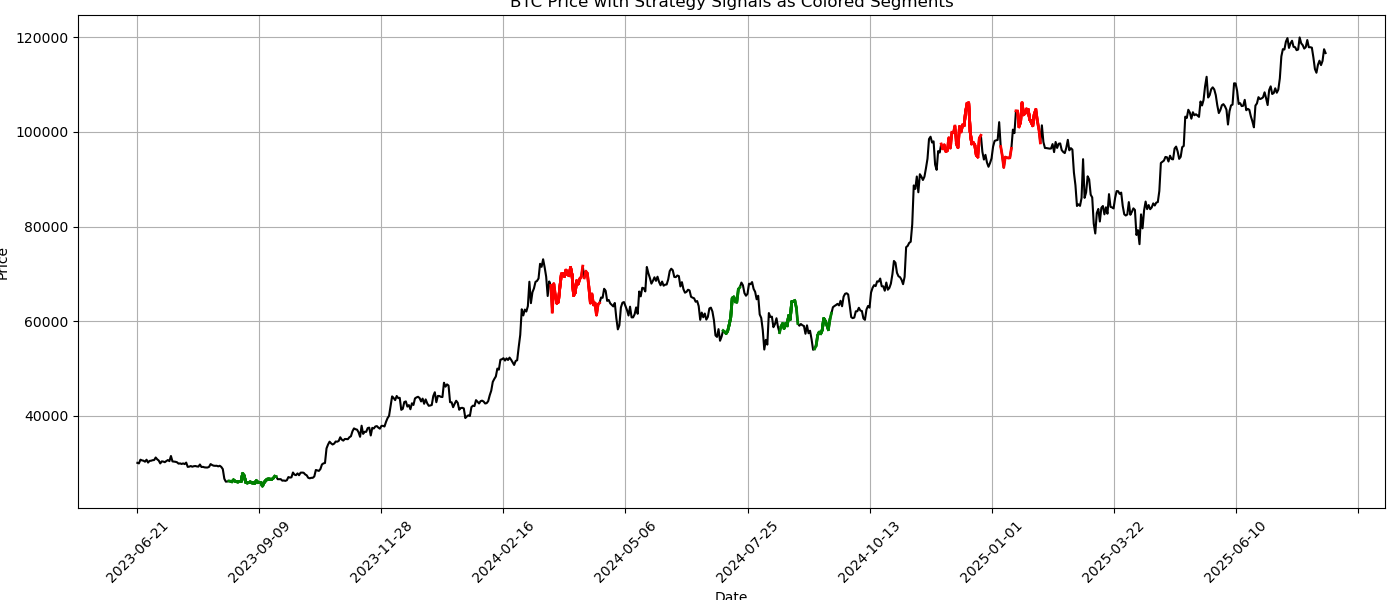

In [97]:
%matplotlib widget

# Aligns price and prediction series
price = market_data['close']
price = price.loc[y_pred.index]
y_pred = y_pred[target]

# Calculates thresholds
s_thresh = np.quantile(y_pred, lq)
l_thresh = np.quantile(y_pred, uq)

# Defines signal masks
s_mask = y_pred <= s_thresh
l_mask = y_pred >= l_thresh

# Converts to numpy arrays for efficient indexing
dates = price.index.to_numpy()
prices = price.values

# Plot with colored line segments
horizon = 7  # Forward steps of the prediction

plt.figure(figsize=(14, 6))

# 1. Plot full BTC price line in light black/gray for context
plt.plot(dates, prices, color='black', linewidth=1.5, label='BTC Price')

# 2. Overlay colored signal-based segments for horizon
for i in range(len(price) - horizon):
    color = None
    if l_mask.iloc[i]:
        color = 'green'
    elif s_mask.iloc[i]:
        color = 'red'

    if color:
        # Plot forward horizon segment
        plt.plot(dates[i:i + horizon + 1], prices[i:i + horizon + 1], color=color, linewidth=2)

# Improve x-axis
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(12))
plt.tight_layout()

plt.title('BTC Price with Strategy Signals as Colored Segments')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

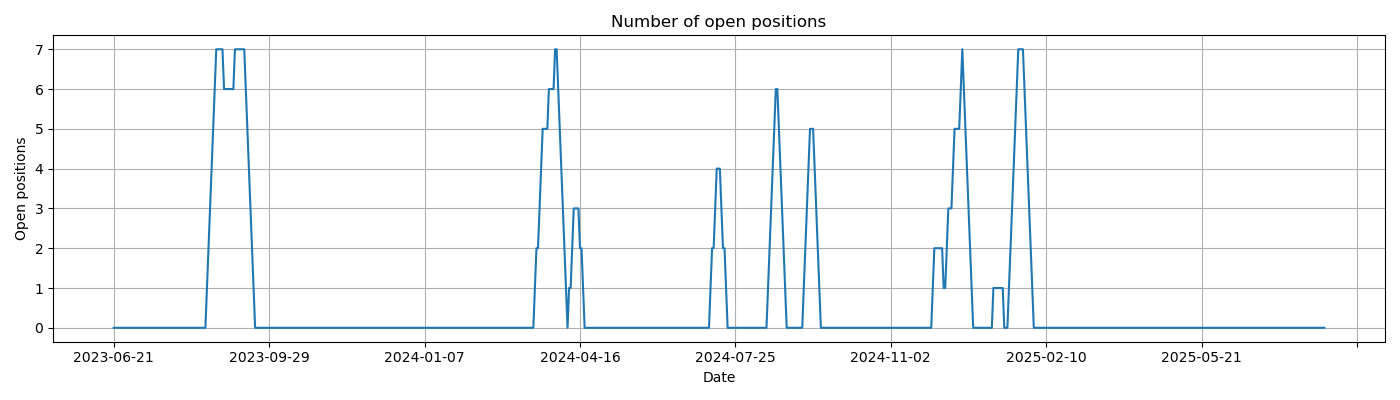

In [98]:
# Convert boolean masks to int: 1 when a position opens
mask = (s_mask | l_mask).astype(int).values  # Combined signal mask
position_lifetime = 7

# Initialize array to count active positions
open_positions = np.zeros(len(mask), dtype=int)

# Accumulate open positions using a rolling window of 'position_lifetime'
for i in range(len(mask)):
    if mask[i] == 1:
        end_idx = min(i + position_lifetime, len(mask))  # Avoid overflow
        open_positions[i:end_idx] += 1

# Convert to pandas Series for convenience
open_positions_series = pd.Series(open_positions, index=price.index)

# Plot the number of open positions over time
plt.figure(figsize=(14, 4))
open_positions_series.plot()
plt.title(f'Number of open positions')
plt.xlabel('Date')
plt.ylabel('Open positions')
plt.grid(True)
plt.tight_layout()
plt.show()

In [99]:
y_true = y_true[target]

# 1. Binary classification: 1 if predicted return > 0
y_pred_bin = (y_pred > 0).astype(int)
y_true_bin = (y_true > 0).astype(int)

# 2. Evaluate directional accuracy
precision = precision_score(y_true_bin, y_pred_bin)
recall = recall_score(y_true_bin, y_pred_bin)
f1 = f1_score(y_true_bin, y_pred_bin)
conf_matrix = confusion_matrix(y_true_bin, y_pred_bin)

# 3. Display results (How often am I right?)
print("Directional Precision:", round(precision, 3))
print("Directional Recall:", round(recall, 3))
print("Directional F1 Score:", round(f1, 3))
print("Confusion Matrix:\n", conf_matrix)

Directional Precision: 0.687
Directional Recall: 0.225
Directional F1 Score: 0.339
Confusion Matrix:
 [[286  46]
 [347 101]]


In [100]:
# Compute returns
long_returns = (np.exp(y_true[l_mask]) - 1).values
short_returns = -(np.exp(y_true[s_mask]) - 1).values  # inverse for shorts
all_returns = np.concatenate([long_returns, short_returns])

# Metrics
cumulative_return = np.prod(1 + all_returns)
volatility = np.std(all_returns, ddof=1)
sharpe = np.mean(all_returns) / volatility

equity_curve = np.cumprod(1 + all_returns)
peak = np.maximum.accumulate(equity_curve)
drawdown = (peak - equity_curve) / peak
max_drawdown = np.max(drawdown)

hit_ratio = np.mean(all_returns > 0)
profit_factor = np.sum(all_returns[all_returns > 0]) / abs(np.sum(all_returns[all_returns < 0]))

print("Sharpe:", sharpe)
print("Cumulative Return:", cumulative_return)
print("Volatility:", volatility)
print("Max Drawdown:", max_drawdown)
print("Hit Ratio:", hit_ratio)
print("Profit Factor:", profit_factor)

Sharpe: 0.3980046808909161
Cumulative Return: 4.752006728182824
Volatility: 0.054326724213507406
Max Drawdown: 0.3634322689710862
Hit Ratio: 0.6410256410256411
Profit Factor: 2.9093336982008653


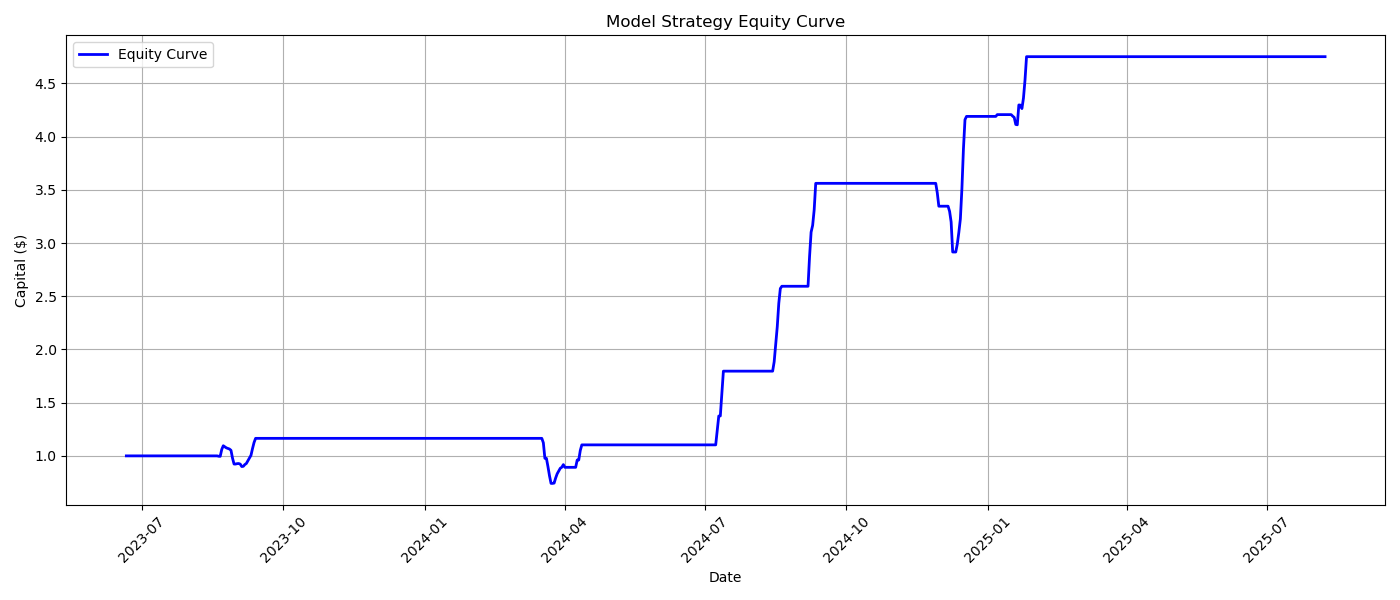

In [101]:
# --- Reconstruct returns from log returns ---
returns = pd.Series(0.0, index=y_true.index)  # Initialize returns with 0, aligned to dates
returns.loc[l_mask] = (np.exp(y_true[l_mask]) - 1).values
returns.loc[s_mask] = -(np.exp(y_true[s_mask]) - 1).values  # short returns are negative

# --- Compute equity curve ---
equity = (1 + returns).cumprod()  # start with 1 capital unit
equity.index = pd.to_datetime(equity.index)  # ensure index is datetime

# --- Plot ---
plt.figure(figsize=(14, 6))
plt.plot(equity.index, equity.values, label='Equity Curve', color='blue', linewidth=2)

# Format x-axis with month-year
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Final plot touches
plt.xticks(rotation=45)
plt.title('Model Strategy Equity Curve')
plt.xlabel('Date')
plt.ylabel('Capital ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Prediction

In [102]:
# Decision threshold
print(f"Short decision threshold:", s_thresh)
print(f"Long decision threshold:", l_thresh)

Short decision threshold: -0.2225700832903385
Long decision threshold: 0.06790461391210555


In [103]:
def get_last_window(X, window_size):
    """
    Extracts the last window of features from the test set for prediction.
    """
    if isinstance(X, (pd.DataFrame, pd.Series)):
        X = X.values
    
    last_window = X[-window_size:]

    return np.expand_dims(last_window, axis=0)

In [104]:
X_last = get_last_window(X_test, int(window_size))
y_last_pred = model.predict(X_last, verbose=0)
print("Prediction:", y_last_pred[0][0])

Prediction: -0.18131602


In [105]:
if y_last_pred < s_thresh:
    print("Decision: Short")
elif y_last_pred > l_thresh:
    print("Decision: Long")
else:
    print("Decision: Neutral")

Decision: Neutral


# Interpretation

In [106]:
# Keeps the original shape of test data
n_samples, window_size, n_features = X_test_seq.shape

# Flattens input for SHAP (2D)
X_flat = X_test_seq.reshape((n_samples, window_size * n_features))

In [107]:
def predict_fn(X_flat_input):
    """
    Prediction wrapper, reshapes test data to fullfill shap requirements
    """
    X_reshaped = X_flat_input.reshape((-1, window_size, n_features))
    
    return model.predict(X_reshaped, verbose=0)

In [108]:
# Reduce background size by randomly sampling K instances
X_background_sampled = shap.sample(X_flat, 100)  # Adjust K as needed

In [109]:
# Initializes the explainer
explainer = shap.KernelExplainer(predict_fn, X_background_sampled)

In [110]:
# Computes SHAP values
# shap_values_flat = explainer.shap_values(X_background_sampled)

In [111]:
# # Reshapes the flattened SHAP values
# shap_values_3d = shap_values_flat[0].reshape((-1, window_size, n_features))  # (samples, timesteps, features)

# # Option A: Last timestep
# shap_last = shap_values_3d[:, -1, :] # shape: (samples, features)
# X_last = X_test_seq[:shap_last.shape[0], -1, :] # ensure alignment
# shap.summary_plot(shap_last, X_last, feature_names=feature_names)

In [112]:
# # Option B: Mean absolute SHAP across time
# shap_avg = np.mean(np.abs(shap_values_3d), axis=1) # shape: (samples, features)
# shap.summary_plot(shap_avg, X_last, feature_names=feature_names)